## Pseudo-elastic Equation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
%matplotlib inline

# Make background for figures white
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
def plot_fn_snapshot(fn, fig=None, axs=None, **kwargs):
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 1)
        im = axs.imshow(fn, **kwargs)
        return fig, axs, im
    
    im = axs.imshow(fn, **kwargs)
    return fig, axs, im

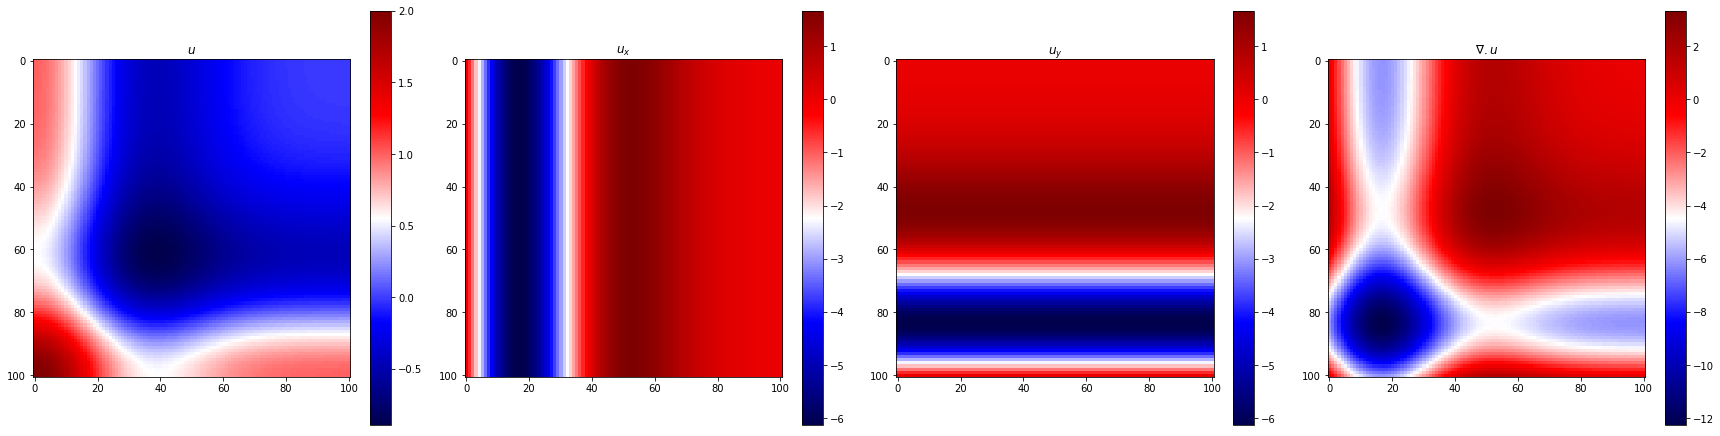

In [25]:
size = (101, 101)
u_initial = np.zeros(size)
u_dx = np.zeros(size)
u_dy = np.zeros(size)
# Set initial condition velocity
f = 1   # Wavelet frequency(Hz(?))
for i in range(size[0]):
    y = 1 - i / (size[0] - 1)
    for j in range(size[1]):
        x = j / (size[1] - 1)
#         Simple sine wave (x)
#         u_initial[i, j] = np.sin(2 * np.pi * x)
#         u_dx[i, j] = 2 * np.pi * np.cos(2 * np.pi * x)
#         u_dy[i, j] = 0

#         Ricker wavelet (x)
        u_initial[i, j] = (
            (1 - 2*np.pi**2*f**2*x**2)*np.exp(-1 * np.pi**2 * f**2 * x**2) +
            (1 - 2*np.pi**2*f**2*y**2)*np.exp(-1 * np.pi**2 * f**2 * y**2)
        )
        u_dy[i, j] = (
                      (np.exp(-1 * np.pi**2 * f**2 * y**2)*(-2*y*np.pi**2 * f**2)) * (1 - 2*np.pi**2*f**2*y**2) + 
                      (-2 * np.pi**2 * f**2 * 2 * y) * np.exp(-1 * np.pi**2 * f**2 * y**2)
                     )
        u_dx[i, j] = (
                      (np.exp(-1 * np.pi**2 * f**2 * x**2)*(-2*x*np.pi**2 * f**2)) * (1 - 2*np.pi**2*f**2*x**2) + 
                      (-2 * np.pi**2 * f**2 * 2 * x) * np.exp(-1 * np.pi**2 * f**2 * x**2)
                     )
#         Simple polynomial
#         u_initial[i, j] = 2 * (x-0.5)**2 - 9 * y
#         u_dx[i, j] = 4 * (x-0.5)
#         u_dy[i, j] = -9

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
_, _, im0 = plot_fn_snapshot(u_initial, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(u_dx, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(u_dy, axs=axs[2], cmap='seismic')
_, _, im3 = plot_fn_snapshot((u_dx + u_dy), axs=axs[3], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
fig.colorbar(im3, ax=axs[3])
axs[0].set_title(r"$u$")
axs[1].set_title(r"$u_x$")
axs[2].set_title(r"$u_y$")
axs[3].set_title(r"$\nabla . u$")
fig.tight_layout(pad=0.5)

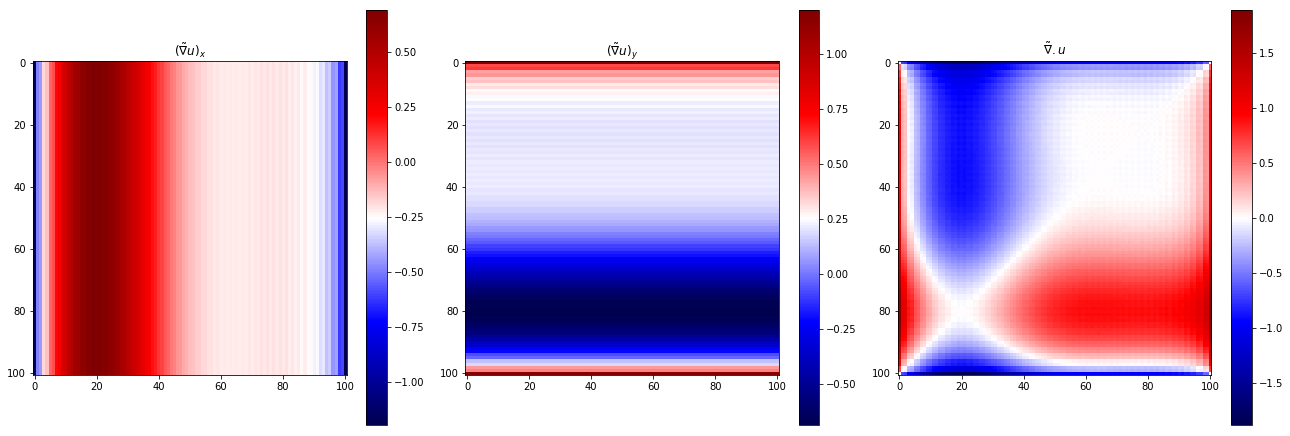

In [26]:
def normalized_gradient(f, dim=2, eps=1e-6):
    size = f.data.shape
    f_x, f_y = fft.fftfreq(size[1]), fft.fftfreq(size[0])
    f_fft = fft.fftn(f)
#     norm_grad = np.zeros((f.shape[0], f.shape[1], dim), dtype=complex)
    ddx = np.zeros(f.shape, dtype=complex)
    ddy = np.zeros(f.shape, dtype=complex)
    for i in range(f_fft.shape[0]):
        for j in range(f_fft.shape[1]):
            k_x, k_y = f_x[j], f_y[i]
            ddx[i, j] = -(1j * k_x) * f_fft[i, j]  / np.sqrt(k_x**2 + k_y**2 + eps)
            ddy[i, j] = -(1j * k_y) * f_fft[i, j]  / np.sqrt(k_x**2 + k_y**2 + eps)
    ddx = fft.ifftn(ddx)
    ddy = fft.ifftn(ddy)
    return ddx, ddy

def normalized_div(f, dim=2, eps=1e-6):
    ddx, ddy = normalized_gradient(f, dim=dim, eps=eps)
    return -(ddx + ddy)

# fig, axs = plt.subplots(1, 2)
ddx, ddy = normalized_gradient(u_initial)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

fig, axs[0], im0 = plot_fn_snapshot(np.real(ddx), fig=fig, axs=axs[0], cmap='seismic')
cbar0 = fig.colorbar(im0, ax=axs[0])
axs[0].set_title(r"$(\tilde{\nabla}u)_x$")

fig, axs[1], im1 = plot_fn_snapshot(np.real(ddy), fig=fig, axs=axs[1], cmap='seismic')
cbar1 = fig.colorbar(im1, ax=axs[1])
axs[1].set_title(r"$(\tilde{\nabla}u)_y$")
n_div = normalized_div(u_initial)
fig, axs[2], im2 = plot_fn_snapshot(np.real(n_div), fig=fig, axs=axs[2], cmap='seismic')
cbar2 = fig.colorbar(im2, ax=axs[2])
axs[2].set_title(r"$\tilde{\nabla} . u$")
fig.tight_layout(pad=0.5)

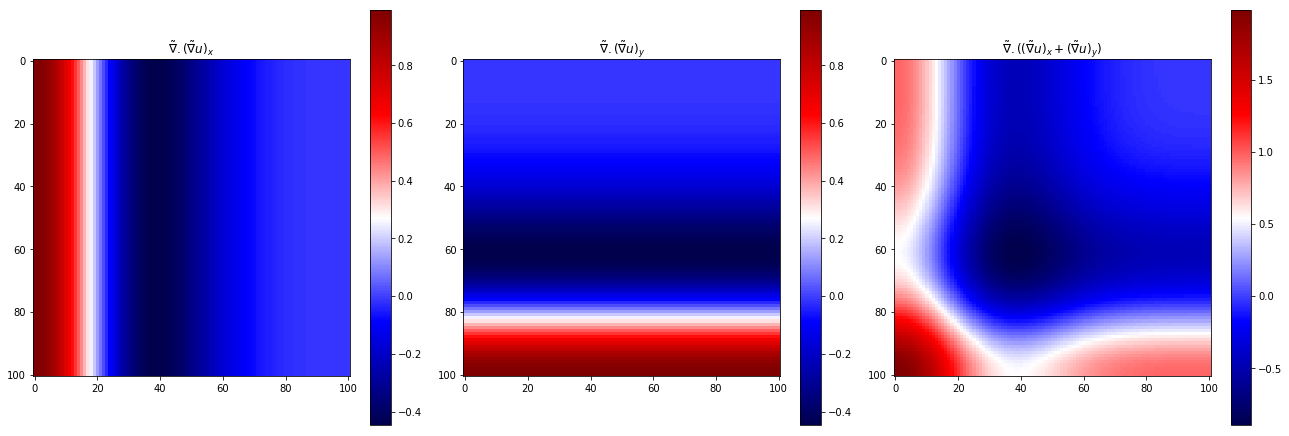

In [29]:
div_ddx = normalized_div(ddx)
div_ddy = normalized_div(ddy)
div_grad_u = div_ddx + div_ddy
# plt.imshow(np.real(div_grad_u), cmap='seismic')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
_, _, im0 = plot_fn_snapshot(np.real(div_ddx), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(div_ddy), fig=fig, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(np.real(div_grad_u), fig=fig, axs=axs[2], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
axs[0].set_title(r"$\tilde{\nabla} . (\tilde{\nabla} u)_x$")
axs[1].set_title(r"$\tilde{\nabla} . (\tilde{\nabla} u)_y$")
axs[2].set_title(r"$\tilde{\nabla} . ((\tilde{\nabla} u)_x + (\tilde{\nabla} u)_y)$")
fig.tight_layout(pad=0.5)

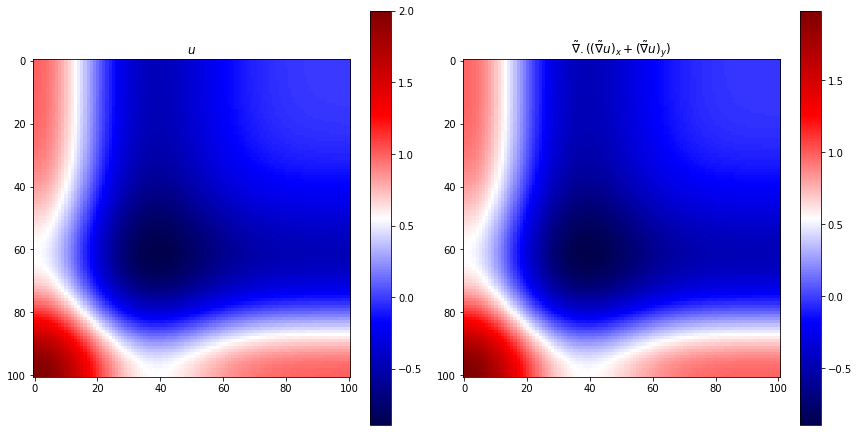

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
_, _, im0 = plot_fn_snapshot(np.real(u_initial), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(div_grad_u), fig=fig, axs=axs[1], cmap='seismic')
axs[0].set_title("$u$")
axs[1].set_title(r"$\tilde{\nabla} . ((\tilde{\nabla} u)_x + (\tilde{\nabla} u)_y)$")
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.tight_layout(pad=0.5)

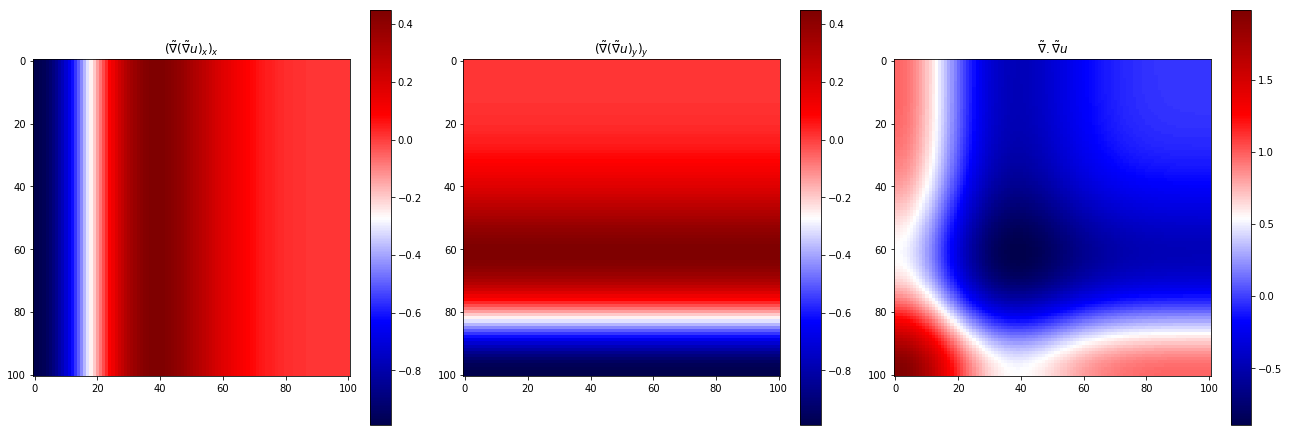

In [31]:
ddx_ddx, _ = normalized_gradient(ddx)
_, ddy_ddy = normalized_gradient(ddy)
laplace_u = -(ddx_ddx + ddy_ddy)
# plt.imshow(np.real(div_grad_u), cmap='seismic')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
_, _, im0 = plot_fn_snapshot(np.real(ddx_ddx), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(ddy_ddy), fig=fig, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(np.real(laplace_u), fig=fig, axs=axs[2], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
axs[0].set_title(r"$(\tilde{\nabla} (\tilde{\nabla} u)_x)_x$")
axs[1].set_title(r"$(\tilde{\nabla} (\tilde{\nabla} u)_y)_y$")
axs[2].set_title(r"$\tilde{\nabla} . \tilde{\nabla} u$")
fig.tight_layout(pad=0.5)

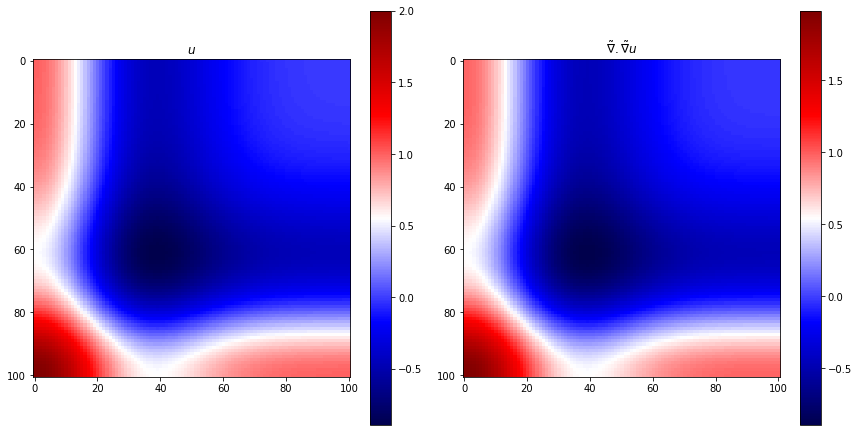

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
_, _, im0 = plot_fn_snapshot(np.real(u_initial), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(laplace_u), fig=fig, axs=axs[1], cmap='seismic')
axs[0].set_title("$u$")
axs[1].set_title(r"$\tilde{\nabla} . \tilde{\nabla} u$")
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.tight_layout(pad=0.5)

## Equation(s)

$$P = \tilde{\nabla} \mathbf{u}$$

$$\partial_{t}^2 P = \tilde{\nabla} \cdot \mathbf{E}\tilde{\nabla}P + \tilde{\nabla} \frac{1}{\rho}(\mathbf{f} + \nabla \cdot \mathbf{m})$$

$$\frac{P_{t+1} + P_{t-1} - 2P_{t}}{dt^2} = \tilde{\nabla} \cdot \mathbf{E}\tilde{\nabla}P^{t} + \tilde{\nabla} s$$
$$\implies P_{t+1} = dt^2\left(\tilde{\nabla} \cdot \mathbf{E}\tilde{\nabla}P^{t} + \tilde{\nabla} s \right) + 2P_{t} - P_{t-1} $$


Consider $\mathbf{E}\tilde{\nabla}P$
$$
\mathbf{E}\tilde{\nabla}P = \begin{bmatrix}
\partial_{x} (\lambda + 2\mu) \partial_{x} + \partial_{y} \mu \partial_{y} &
\partial_{x} \lambda \partial_{y} + \partial_y \mu \partial_{x}\\
\partial_{y} \lambda \partial_{x} + \partial_{x} \mu \partial_{y}  &
\partial_{x}\mu\partial_{x} + \partial_{y} (\lambda + 2 \mu) \partial_{y}
\end{bmatrix}
.
\begin{bmatrix}
(\tilde{\nabla}P)_{x}\\
(\tilde{\nabla}P)_{y}
\end{bmatrix}
$$

Assuming constant $\lambda, \mu$, we have

$$
\mathbf{E}\tilde{\nabla}P = \begin{bmatrix}
(\lambda + 2\mu) \partial^{2}_{x} + \mu \partial^{2}_{y} &
(\lambda + \mu) \partial_{x} \partial_{y}\\
(\lambda + \mu) \partial_{x} \partial_{y} &
(\lambda + 2\mu) \partial^{2}_{y} + \mu \partial^{2}_{x}
\end{bmatrix}
.
\begin{bmatrix}
(\tilde{\nabla}P)_{x}\\
(\tilde{\nabla}P)_{y}
\end{bmatrix}
$$
$$
= \begin{bmatrix}
(\lambda + 2\mu) \partial^{2}_{x} + \mu \partial^{2}_{y} ((\tilde{\nabla}P)_{x}) \;+\;(\lambda + \mu) \partial_{x} \partial_{y} ((\tilde{\nabla}P)_{y})\\
(\lambda + \mu) \partial_{x} \partial_{y} ((\tilde{\nabla}P)_{x}) \;+\; ((\lambda + 2\mu) \partial^{2}_{y} + \mu \partial^{2}_{x}) ((\tilde{\nabla}P)_y)
\end{bmatrix}
$$

In [ ]:
def s(t, f=10):
    return (1 - 2*np.pi**2*f**2*t**2)*np.exp(-1 * np.pi**2 * f**2 * t**2)

P_x, P_y = normalized_gradient(u_initial)
P_x_next, P_y_next = np.array(P_x), np.array(P_y)
P_x_prev, P_y_prev = np.array(P_x), np.array(P_y)
dt = 0.01
tn = 1 * dt
t0 = 0
t = t0
lam = 1
mu = 0.5
dx = 0.1

while t < tn:
    P_xx, P_xy = normalized_gradient(P_x)
    P_yx, P_yy = normalized(gradient(P_y))
    grad_Px = P_xx + P_yx
    grad_Py = P_xy + P_yy
    # Assume constant lambda and mu for now
    for i in range(1, size[0]-1):
        for j in range(1, size[1]-1):
            dx_grad_Px = (grad_Px[j+1] - grad_Px[j-1]) / (2*dx)
            dx2_grad_Px = (grad_Px[j+1] + grad_Px[j-1] - 2 * grad_Px[j]) / (dx**2)
            dy_grad_Px = (grad_Px[i-1] - grad_Px[i+1]) / (2*dx)
            dy2_grad_Px = (grad_Px[i-1] + grad_Px[i+1] - 2*grad_Px[i]) / (2*dx)
            dxdy_grad_Px = (dx_grad_Px[i-1] - dx_grad_Px[i+1]) / (2*dx)
            
            dx_grad_Py = (grad_Py[j+1] - grad_Py[j-1]) / (2*dx)
            dx2_grad_Py = (grad_Py[j+1] + grad_Py[j-1] - 2 * grad_Py[j]) / (dx**2)
            dy_grad_Py = (grad_Py[i-1] - grad_Py[i+1]) / (2*dx)
            dy2_grad_Py = (grad_Py[i-1] + grad_Py[i+1] - 2 * grad_Py[i]) / (dx**2)
            dxdy_grad_Py = (dy_grad_Py[j+1] - dy_grad_Py[j-1]) / (2 * dx)
            
            E_gradP_x = (lam + 2*mu)*dx2_grad_Px + mu * dy2_grad_Px + (lam + mu)*dxdy_grad_Py
            E_gradP_y = (lam + mu)*dxdy_grad_Px + (lam + 2*mu) * dy2_grad_Py + mu * dx2_grad_Py
            
            EgPx_ddx, EgPx_ddy = normalized_gradient(E_gradP_x)
            EgPy_ddx, EgPy_ddy = normalized_gradient(E_gradP_y)
            EgP_div = -(EgPx_ddx + EgPy_ddy)
            
            
            
    t += dt
